##### Sprintの目的
スクラッチを通してCNNの基礎を理解する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from decimal import Decimal, ROUND_HALF_UP

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#np.set_printoptions(threshold=0)

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

##### データセットの用意

引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

MNISTはデータサイズが大きいので、いったん[Optical Recognition of Handwritten Digits Data Set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)のコピーである、[sklearn.datasets.load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)を使って、正しく動いているか検証してみましょう。

In [2]:
# from sklearn.datasets import load_digits
# np.set_printoptions(threshold=np.inf)

# X,y = load_digits(n_class = 10, return_X_y = True)
# X = X.reshape((-1,8,8))

# for i in range(10):
#     print(y[i])
#     plt.imshow(X[i],"gray")
#     plt.show()

In [3]:
#X_train,X_test,y_train,y_test = train_test_split(X,y)

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

#正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train[:500], y_train_one_hot[:500], test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

Using TensorFlow backend.


(400, 1, 28, 28) (400, 10)
(100, 1, 28, 28) (100, 10)


### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_h -1}\sum_{t=0}^{F_w -1}x_{(i + s),(j +t), k}w_{s, t, k, m} + b_m
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w'_{s,t,k,m} = w_{s,t,k,m} - α\frac{∂L}{∂w_{s,t,k,m}}
$$
$$
b'_m = b_m -  α\frac{∂L}{∂b_m}
$$


$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out, h}-1}\sum_{j=0}^{N_{out, w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$$
\frac{\partial L}{\partial b_m} = \sum_{i=0}^{N_{out, h}-1}\sum_{j=0}^{N_{out, w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_h -1}\sum_{t=0}^{F_w -1}\frac{\partial L}{\partial x_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数

ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

#### im2col
[im2col関数の理解](https://qiita.com/kurumen-b/items/236c6255959a266cefaa)

In [5]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1) #軸の順番入れ替え、reshape
    return col

In [6]:
#チャンネル=1

input_data = np.arange(36).reshape(1, 1, 6, 6) #データ数、チャンネル、 高さ、 幅
w = np.ones((4, 1, 3, 3)) #フィルター数、チャンネル、 高さ、 幅
display(input_data)
#display(w)
display(im2col(input_data, 3, 3))
print(im2col(input_data, 3, 3).shape)

array([[[[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23],
         [24, 25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34, 35]]]])

array([[ 0.,  1.,  2.,  6.,  7.,  8., 12., 13., 14.],
       [ 1.,  2.,  3.,  7.,  8.,  9., 13., 14., 15.],
       [ 2.,  3.,  4.,  8.,  9., 10., 14., 15., 16.],
       [ 3.,  4.,  5.,  9., 10., 11., 15., 16., 17.],
       [ 6.,  7.,  8., 12., 13., 14., 18., 19., 20.],
       [ 7.,  8.,  9., 13., 14., 15., 19., 20., 21.],
       [ 8.,  9., 10., 14., 15., 16., 20., 21., 22.],
       [ 9., 10., 11., 15., 16., 17., 21., 22., 23.],
       [12., 13., 14., 18., 19., 20., 24., 25., 26.],
       [13., 14., 15., 19., 20., 21., 25., 26., 27.],
       [14., 15., 16., 20., 21., 22., 26., 27., 28.],
       [15., 16., 17., 21., 22., 23., 27., 28., 29.],
       [18., 19., 20., 24., 25., 26., 30., 31., 32.],
       [19., 20., 21., 25., 26., 27., 31., 32., 33.],
       [20., 21., 22., 26., 27., 28., 32., 33., 34.],
       [21., 22., 23., 27., 28., 29., 33., 34., 35.]])

(16, 9)


In [7]:
w = np.ones((4, 1, 3, 3)) #フィルター数、チャンネル、 高さ、 幅
display(w)
display(w.reshape(4, -1).T)
print(w.reshape(4, -1).T.shape)

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

(9, 4)


In [8]:
#チャンネル数=3

input_data = np.arange(108).reshape(1, 3, 6, 6) #データ数、チャンネル、 高さ、 幅
w = np.ones((4, 3, 3, 3)) #フィルター数、チャンネル、 高さ、 幅
display(input_data)
#display(w)
display(im2col(input_data, 3, 3))
print(im2col(input_data, 3, 3).shape)

array([[[[  0,   1,   2,   3,   4,   5],
         [  6,   7,   8,   9,  10,  11],
         [ 12,  13,  14,  15,  16,  17],
         [ 18,  19,  20,  21,  22,  23],
         [ 24,  25,  26,  27,  28,  29],
         [ 30,  31,  32,  33,  34,  35]],

        [[ 36,  37,  38,  39,  40,  41],
         [ 42,  43,  44,  45,  46,  47],
         [ 48,  49,  50,  51,  52,  53],
         [ 54,  55,  56,  57,  58,  59],
         [ 60,  61,  62,  63,  64,  65],
         [ 66,  67,  68,  69,  70,  71]],

        [[ 72,  73,  74,  75,  76,  77],
         [ 78,  79,  80,  81,  82,  83],
         [ 84,  85,  86,  87,  88,  89],
         [ 90,  91,  92,  93,  94,  95],
         [ 96,  97,  98,  99, 100, 101],
         [102, 103, 104, 105, 106, 107]]]])

array([[  0.,   1.,   2.,   6.,   7.,   8.,  12.,  13.,  14.,  36.,  37.,
         38.,  42.,  43.,  44.,  48.,  49.,  50.,  72.,  73.,  74.,  78.,
         79.,  80.,  84.,  85.,  86.],
       [  1.,   2.,   3.,   7.,   8.,   9.,  13.,  14.,  15.,  37.,  38.,
         39.,  43.,  44.,  45.,  49.,  50.,  51.,  73.,  74.,  75.,  79.,
         80.,  81.,  85.,  86.,  87.],
       [  2.,   3.,   4.,   8.,   9.,  10.,  14.,  15.,  16.,  38.,  39.,
         40.,  44.,  45.,  46.,  50.,  51.,  52.,  74.,  75.,  76.,  80.,
         81.,  82.,  86.,  87.,  88.],
       [  3.,   4.,   5.,   9.,  10.,  11.,  15.,  16.,  17.,  39.,  40.,
         41.,  45.,  46.,  47.,  51.,  52.,  53.,  75.,  76.,  77.,  81.,
         82.,  83.,  87.,  88.,  89.],
       [  6.,   7.,   8.,  12.,  13.,  14.,  18.,  19.,  20.,  42.,  43.,
         44.,  48.,  49.,  50.,  54.,  55.,  56.,  78.,  79.,  80.,  84.,
         85.,  86.,  90.,  91.,  92.],
       [  7.,   8.,   9.,  13.,  14.,  15.,  19.,  20.,  21.,  43

(16, 27)


In [9]:
w = np.ones((4, 3, 3, 3)) #フィルター数、チャンネル、 高さ、 幅
display(w)
display(w.reshape(4, -1).T)
print(w.reshape(4, -1).T.shape)

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

(27, 4)


In [10]:
#forwardの中
input_data = np.arange(108).reshape(1, 3, 6, 6) #データ数、チャンネル、 高さ、 幅
w = np.ones((4, 3, 3, 3)) #フィルター数、チャンネル、 高さ、 幅

A = im2col(input_data, 3, 3)@w.reshape(4, -1).T
display(A)
A = A.reshape(1, 4, 4, -1).transpose(0, 3, 1, 2)
display(A)
print(A.shape)

array([[1161., 1161., 1161., 1161.],
       [1188., 1188., 1188., 1188.],
       [1215., 1215., 1215., 1215.],
       [1242., 1242., 1242., 1242.],
       [1323., 1323., 1323., 1323.],
       [1350., 1350., 1350., 1350.],
       [1377., 1377., 1377., 1377.],
       [1404., 1404., 1404., 1404.],
       [1485., 1485., 1485., 1485.],
       [1512., 1512., 1512., 1512.],
       [1539., 1539., 1539., 1539.],
       [1566., 1566., 1566., 1566.],
       [1647., 1647., 1647., 1647.],
       [1674., 1674., 1674., 1674.],
       [1701., 1701., 1701., 1701.],
       [1728., 1728., 1728., 1728.]])

array([[[[1161., 1188., 1215., 1242.],
         [1323., 1350., 1377., 1404.],
         [1485., 1512., 1539., 1566.],
         [1647., 1674., 1701., 1728.]],

        [[1161., 1188., 1215., 1242.],
         [1323., 1350., 1377., 1404.],
         [1485., 1512., 1539., 1566.],
         [1647., 1674., 1701., 1728.]],

        [[1161., 1188., 1215., 1242.],
         [1323., 1350., 1377., 1404.],
         [1485., 1512., 1539., 1566.],
         [1647., 1674., 1701., 1728.]],

        [[1161., 1188., 1215., 1242.],
         [1323., 1350., 1377., 1404.],
         [1485., 1512., 1539., 1566.],
         [1647., 1674., 1701., 1728.]]]])

(1, 4, 4, 4)


In [11]:
(im2col(input_data, 3, 3)@w.reshape(4, -1).T).shape

(16, 4)

#### col2im
[col2im徹底理解](https://qiita.com/kuroitu/items/7877c002e192955c7857)

In [12]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

#### 回答

In [22]:
class Conv2d:
    def __init__(self, initializer, optimizer, stride=1, pad=0):
        self.w = initializer.w(4, 1, 24, 24)
        self.b = initializer.b(1)
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        
        self.X =None
        self.col = None
        self.col_w = None
        
        self.dw = None
        self.db = None
    
    def forward(self, X):
        FN, C, FH, FW = self.w.shape #フィルター数、チャンネル、フィルター高さ、フィルター幅
        N, C, H, W = X.shape #バッチ数、チャンネル、データ高さ、データ幅
        
        out_h, out_w = calc_out_shape((H, W), (FH, FW), self.stride, self.pad)
        col = im2col(X, FH, FW, self.stride, self.pad) #Xを2d配列に
        col_w = self.w.reshape(FN, -1).T #フィルターを2d配列に
        
        out = np.dot(col, col_w) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.X = X
        self.col = col
        self.col_w = col_w
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.w.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dw = np.dot(self.col.T, dout)
        self.dw = self.dw.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_w.T)
        dx = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        self = self.optimizer.update(self)

        return dx

In [23]:
#Full Connected Layer Class
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        
    def forward(self, X):
        self.X = X
        out = np.dot(self.X, self.w) + self.b
        return out
    
    def backward(self, dout):
        dX = np.dot(dout, self.w.T)
        self.dw = np.dot(self.X.T, dout)
        self.db = np.sum(dout, axis=0, keepdims=True)
        
        # 重みとバイアスの更新
        self = self.optimizer.update(self)
        return dX
    
###########################
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.w = layer.w - self.lr*layer.dw
        layer.b = layer.b - self.lr*layer.db

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_w = 0
        self.h_b = 0
        
    def update(self, layer):
        self.h_w = self.h_w + (layer.dw**2).sum()
        self.h_b = self.h_b + (layer.db**2).sum()
        
        layer.w = layer.w - self.lr*(1/np.sqrt(self.h_w) + 1e-7)*layer.dw #「1e-7」で0での除算を防ぐ
        layer.b = layer.b - self.lr*(1/np.sqrt(self.h_b) + 1e-7)*layer.db
        
#################################
class XavierInitializer:
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

class XavierInitializer_conv:
    def __init__(self):
        self.sigma = None
        
    def w(self, FN, C, FH, FW):
        self.sigma = 1/np.sqrt(FN)
        w = self.sigma * np.random.randn(FN, C, FH, FW) #重みの初期値（畳み込み層）
        return w

    def b(self, FN):
        self.sigma = 1/np.sqrt(FN)
        b = self.sigma * np.random.randn(FN) #バイアスの初期値
        return b

###############################
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

##################################
class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def _softmax(self, X):
        X = X - np.max(X, axis=-1, keepdims=True)
        y = np.exp(X) / np.sum(np.exp(X), axis=-1, keepdims=True)
        
        return y
    
    def forward(self, X, t):
        self.t = t
        self.y = self._softmax(X)
        self.loss = self._cross_entropy_error(self.y, self.t)
        return self.loss
    
    def _cross_entropy_error(self, y, t):     
        batch_size = y.shape[0]
        return -np.sum(t * np.log(y + 1e-7)) / batch_size
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dX = (self.y - self.t)/batch_size
        return dX

### 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} = \frac{N_{h,in}+2P_h-F_h}{S_h} + 1
$$
$$
N_{w,out} = \frac{N_{w,in}+2P_w-F_w}{S_w} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

#### 回答

In [1]:
def calc_out_shape(input_shape, filter_shape, stride=1, pad=0):
    in_h, in_w = input_shape
    f_h, f_w = filter_shape
    out_h = int((in_h + 2*pad - f_h)//stride + 1)
    out_w = int((in_w + 2*pad - f_w)//stride + 1)
    return out_h, out_w

In [17]:
#検証
calc_out_shape((6, 6), (3, 3))

(4, 4)

### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。
バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。



#### 回答

In [30]:
class MaxPool2D:
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.X = None
        self.arg_max = None

    def forward(self, X):
        N, C, H, W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.X = X
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。



### 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

#### 回答

In [34]:
#(N, C, H ,W)

class Flatten:
    def __init__(self):
        self.channel = None
        self.height = None
        self.width = None
    
    def forward(self, X):
        self.channel = X.shape[1]
        self.height = X.shape[2]
        self.width = X.shape[3]
        return X.reshape(X.shape[0], -1)

    def backward(self, dout):
        return dout.reshape(dout.shape[0], self.channel, self.height, self.width)

### 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

#### 回答

In [39]:
from collections import OrderedDict

class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, batch_size=20, max_iter=3):
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.train_loss = []
        self.test_loss = []
        
        # レイヤの生成
        initializer = XavierInitializer()
        initializer_conv = XavierInitializer_conv()
        optimizer = SGD(lr=lr)
        self.layers = OrderedDict()
        self.layers["Conv2d_1"] = Conv2d(initializer_conv, optimizer)
        self.layers["ReLU_1"] = Relu()
        self.layers["Pooling_1"] = MaxPool2D(stride=2)
        self.layers["Flatten"] = Flatten()
        self.layers["FC1"] = FC(16, 100, initializer, optimizer)
        self.layers["ReLU_2"] = Relu()
        self.layers["FC2"] = FC(100, 50, initializer, optimizer)
        self.layers["ReLU_3"] = Relu()
        self.layers["FC3"] = FC(50, 10, initializer, optimizer)
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
            
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_loss_train = []
            tmp_loss_val = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                batch_mask_val = np.random.choice(X_val.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                X_val_batch = X_val[batch_mask_val]
                y_val_batch = y_val[batch_mask_val]
                
                self.gradient(X_batch, y_batch)
                
                loss = self.loss(X_batch, y_batch)
                tmp_loss_train.append(loss)
                if (X_val is not None) and (y_val is not None):
                    loss_test = self.loss(X_val_batch, y_val_batch)
                    tmp_loss_val.append(loss_test)
            
            self.train_loss.append(sum(tmp_loss_train)/len(tmp_loss_train))
            self.test_loss.append(sum(tmp_loss_val)/len(tmp_loss_val))
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)
        
        return self.lastLayer.forward(X, t)

    def gradient(self, X, t):
        self.loss(X, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

In [40]:
dnn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, batch_size=20, max_iter=10)
dnn.fit(X_train, y_train, X_val, y_val)

In [43]:
from sklearn.metrics import accuracy_score

y_val = np.argmax(y_val, axis=1)
y_pred = dnn.predict(X_val)

print("予測：", y_pred)
print("正答率:{}".format(accuracy_score(y_pred, y_val)))

予測： [3 6 9 7 7 0 2 9 0 2 9 1 6 8 9 7 8 6 0 1 1 1 5 3 8 2 2 8 1 1 1 9 6 9 0 0 5
 2 4 9 0 4 7 6 4 9 7 2 8 4 6 6 4 3 2 7 6 3 7 1 4 3 0 3 1 7 2 1 7 4 2 4 3 0
 3 9 2 9 4 6 4 4 6 0 7 4 3 1 3 0 2 3 7 4 2 2 1 9 8 2]
正答率:0.83


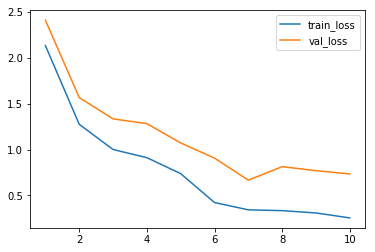

In [44]:
plt.plot(np.arange(1, len(dnn.train_loss)+1), dnn.train_loss, label="train_loss")
plt.plot(np.arange(1, len(dnn.train_loss)+1), dnn.test_loss, label="val_loss")
plt.legend()
plt.show()

### 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

![](https://t.gyazo.com/teams/diveintocode/83358987a273743a589b9388dfdf59ac.png)

※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数


### 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》


[Applications - Keras Documentation](https://keras.io/ja/applications/)

### 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.


- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

2.


- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

3.


- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

#### 回答

In [2]:
#1.
print("出力サイズ：", calc_out_shape((144, 144), (3, 3)))
print("パラメータ数：", 3*3*3*6 + 6)

出力サイズ： (142, 142)
パラメータ数： 168


In [3]:
#2.
print("出力サイズ：", calc_out_shape((60, 60), (3, 3)))
print("パラメータ数：", 24*3*3*48 + 48)

出力サイズ： (58, 58)
パラメータ数： 10416


In [4]:
#3.
print("出力サイズ：", calc_out_shape((20, 20), (3, 3), stride=2))
print("パラメータ数：", 10*3*3*20 + 20)

出力サイズ： (9, 9)
パラメータ数： 1820


### 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果